In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

trans = transforms.Compose([transforms.ToTensor()])

train_dataset = dset.MNIST('./data', train=True, transform=trans, download=True)
test_dataset = dset.MNIST('./data', train=False, transform=trans, download=True)

In [3]:
batch_size = 64
n_epochs = 10
print_every = 100
torch.manual_seed(13)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

In [4]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_name='Generator Network'
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv3 .weight)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv4 .weight)
        
    def forward(self):
        x = 2 * torch.rand((batch_size, 1, 28, 28)) - 1
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        return x

class DiscriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_name='Discriminator Network'
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.fc = nn.Linear(28*28*32, 1)
        
    def forward(self,x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        return self.fc(x.view(-1,28*28*32))
    
def generator_loss(fake_scores):
    return torch.mean((fake_scores - 1)**2)/2

def discriminator_loss(real_scores, fake_scores):
    return torch.mean((real_scores - 1)**2)/2 + torch.mean((fake_scores)**2)/2
    

In [10]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap="gray")

# TRAIN

Iter: 0, D: 0.5215, G:8.11


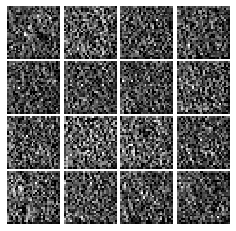

In [ ]:
generator_model = GeneratorNet()
discriminator_model = DiscriminatorNet()

generator_lr = 0.001
discriminator_lr = 0.001

critarion = nn.BCELoss()

generator_optimizer = optim.Adam(generator_model.parameters(), lr=generator_lr)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=discriminator_lr)

generator_model.to(device)
discriminator_model.to(device)

generator_model.train()
discriminator_model.train()

best_g_model = None
best_d_model = None
best_g_loss = 9999999
best_d_loss = 9999999

for epoch in range(1,n_epochs+1):
    for idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device, dtype=dtype), label.to(device, dtype=dtype)
        
        discriminator_optimizer.zero_grad()
        
        out_real = discriminator_model(data)
        
        fake_data = generator_model()
        out_fake = discriminator_model(fake_data.view(batch_size, 1, 28, 28))
        
        d_total_error = discriminator_loss(out_real, out_fake)
        d_total_error.backward()        
        discriminator_optimizer.step()
        
        generator_optimizer.zero_grad()

        fake_data = generator_model()
        out_fake = discriminator_model(fake_data.view(batch_size, 1, 28, 28))
        
        g_error = generator_loss(out_fake)
        g_error.backward()
        generator_optimizer.step()
        
        if idx % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(idx,d_total_error.item(),g_error.item()))
            imgs_numpy = fake_data.data.cpu().numpy().reshape(batch_size,-1)
            show_images(imgs_numpy[0:16])
            plt.show()
            print()
            
            if d_total_error < best_d_loss:
                best_d_loss = d_total_error
                best_d_model = discriminator_model
                
            if g_error < best_g_loss:
                best_g_loss = g_error
                best_g_model = generator_model
        

# PREDICT

In [ ]:
for epoch in range(1,n_epochs+1):
    for idx, (data, label) in enumerate(test_loader):
        with torch.no_grad():
            data, label = data.to(device, dtype=dtype), label.to(device, dtype=dtype)
            
            out_real = discriminator_model(data)
            fake_data = generator_model()
            out_fake = discriminator_model(fake_data.view(batch_size, 1, 28, 28))
            
            print(out_fake)
        # out_real ve out_fake içinde 10 eleman var, en büyük olanı al, aynı index mi bak, oradan pred hesapla
        
        
        